# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [2]:
TFile *f = TFile::Open("ttbar_8TeV.root"); 

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "JetRecoTree". We will then print the contents of the tree to find the names of the variables. 

In [3]:
TTree *tree = (TTree*) f->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

Activate variables 

In [4]:
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];  
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_MV1[10];


tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_MV1);



Create Canvas

In [5]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

Create histograms: Leading jet pT and all jets pT 

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);

# Cuts for Monte-Carlo data without scaling:

In [8]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    cutflow->Fill(0);
    // First cut: good vertex
    if(!good_vtx) continue;
        cut1++;
        cutflow->Fill(1);
    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
        cut2++;
        cutflow->Fill(2);
    
    
    //Loop over leptons
    int n_lep=0;
    for(unsigned int i=0; i<lep_n; i++){
        int n_mu=0;
        int n_el=0;
        if( lep_pt[i] <= 25000.) continue;
        if( lep_ptcone30[i]/lep_pt[i] >= 0.15 ) continue;
        if( lep_etcone20[i]/lep_pt[i] >= 0.15 ) continue;
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){n_mu++;}
        if( lep_type [i]==11 && (TMath::Abs(lep_eta[i])< 2.47 && TMath::Abs(lep_eta[i])>1.52 || TMath::Abs(lep_eta[i])<1.37 )){n_el++;}
        if(n_mu == 0 && n_el == 0) continue;
        n_lep++; 
    }
    
    
    //Third cut: one good lepton
    if(n_lep!=1) continue;
        cutflow->Fill(3); 
        cut3++;
    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
        cutflow->Fill(4); 
        cut4++;
    
    
    //Loop over jets
    int n_jets=0;
    int n_bjets=0;
    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] <= 25000.) continue;
        if(TMath::Abs(jet_eta[j]) >= 2.5) continue;
        if(jet_pt[j] < 50000. && TMath::Abs(jet_eta[j])<2.4 && TMath::Abs(jet_jvf[j]>0.5)){n_jets++;}
        if(jet_pt[j] >= 50000. || TMath::Abs(jet_eta[j])>=2.4){n_jets++;}
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j]>=0.7892){n_bjets++;}
    }
    
    
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    //Sixth cut: at least one b-jet
    if(n_bjets<2) continue;
    cutflow->Fill(6); 
    cut6++;
    //Seventh cut: MET > 30 GeV
    if(MET<=30000.) continue;
    cutflow->Fill(7); 
    cut7++;
    
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    float mTW; 
    
    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    MeT.SetPtEtaPhiE(MET,0.,MET_phi,MET);
    
    //Calculation of the mTW using TLorentz vectors      
    mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    
    //Eight cut: mTW > 30 GeV*/
    if(mTW<=30000.) continue;
    cutflow->Fill(8); 
    cut8++;
    
    
}
        
std::cout << "cut0:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;


cut0:1500000
Cut1:1499487
Cut2:1499487
Cut3:1336213
Cut4:623272
Cut5:622124
Cut6:259921
Cut7:214524
Cut8:180981


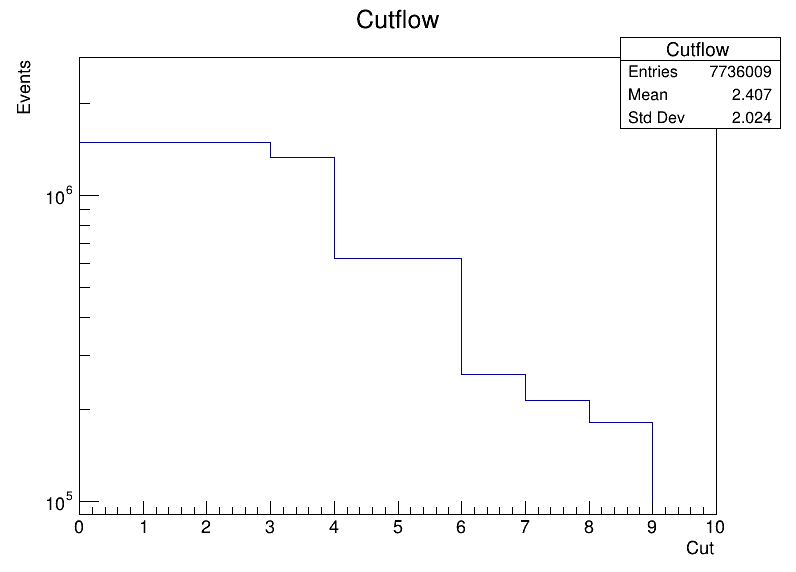

In [9]:
cutflow->Draw("");
canvas->SetLogy();
canvas->Draw();

# Histograms before cuts for Monte Carlo data without scaling:

In other words, how the raw Monte Carlo data looks like? 

In [7]:
TH1F *hist_lep_pt = new TH1F("Lepton pT","lepton pT; pT(GeV);Events",50,0,1000);
TH1F *hist_lep_trackiso = new TH1F("Lepton track isolation","lep_ptcone30/lep_pt; track isolation; Events",100,0,1.5);
TH1F *hist_lep_caloiso = new TH1F("Lepton calorimeter isolation","lep_etcone20/lep_pt; calorimeter isolation; Events",100,0,1.5);
TH1F *hist_lep_eta = new TH1F("Lepton eta","Lepton eta; eta; Events",100,-3,3);

TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);
TH1F *hist_jet_pt = new TH1F("Jet pT","jet pT; pT(GeV);Events",50,10,300);
TH1F *hist_jet_eta = new TH1F("Jet eta","jet eta; eta; Events",100,-3,3);
TH1F *hist_jet_jvf = new TH1F("Jet jvf","jet jvf; jvf; Events",100,-1,1);
TH1F *hist_jet_MV1 = new TH1F("Jet MV1","jet MV1; MV1; Eventss",100,0,1);

TH1F *hist_nbjets = new TH1F("Number of b-jets","n-bjets; Jet multiplicity; Events",10,0,10);

TH1F *hist_MET = new TH1F("Energía perdida","MET; MET(GeV); Events",100,0,1000);

TH1F *hist_mT = new TH1F("Masa reconstuida del W","mT; mT(GeV); Events",100,10,200);


In [8]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();


for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    
    //Loop over leptons
    for(unsigned int j=0; j<lep_n; j++){
        hist_lep_pt->Fill(lep_pt[j]/1000);
        hist_lep_trackiso->Fill(lep_ptcone30[j]/lep_pt[j]);
        hist_lep_caloiso->Fill(lep_etcone20[j]/lep_pt[j]);
        hist_lep_eta->Fill(lep_eta[j]);
    }

    
    //Loop over jets 
    int n_bjets=0;
    hist_njets->Fill(jet_n);
    for(unsigned int k=0; k<jet_n; k++){
       hist_jet_pt->Fill(jet_pt[k]/1000);
       hist_jet_jvf->Fill(jet_jvf[k]);
       hist_jet_MV1->Fill(jet_MV1[k]);
       hist_jet_eta->Fill(jet_eta[k]);
       // b-jets
       if(jet_pt[k] <= 25000.) continue;
       if(TMath::Abs(jet_eta[k]) >= 2.5) continue;
       if(jet_MV1[k]>=0.7892){n_bjets++;} 
       hist_nbjets->Fill(n_bjets);
    }
    
    
    
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    float mTW; 
    
    //Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    MeT.SetPtEtaPhiE(MET,0.,MET_phi,MET);
    hist_MET->Fill(MET/1000);
    
    //Calculation of the mTW using TLorentz vectors      
    mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    hist_mT->Fill(mTW/1000);
    
}
        


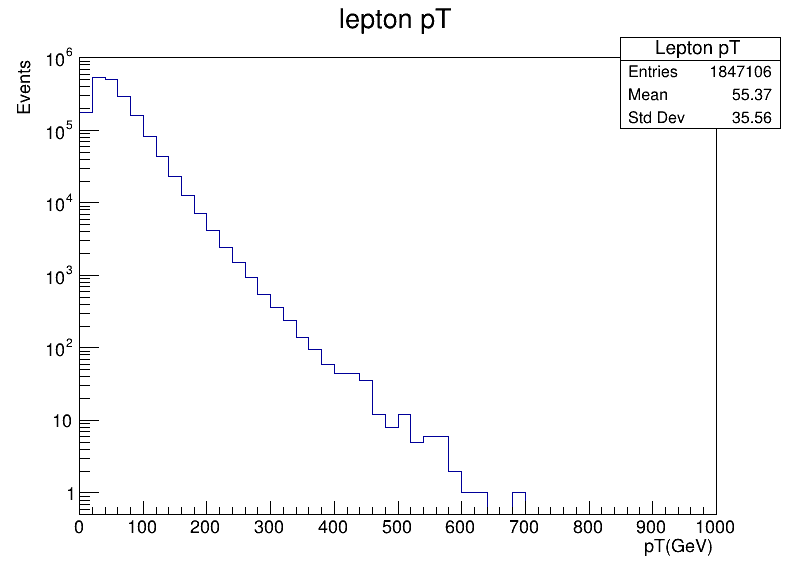

In [12]:
hist_lep_pt->Draw();
canvas->SetLogy();
canvas->Draw();

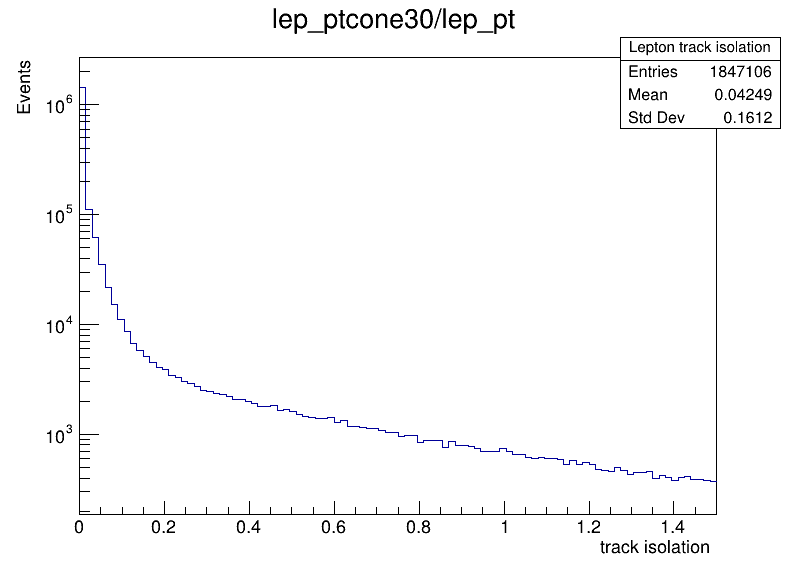

In [13]:
hist_lep_trackiso->Draw();
canvas->SetLogy();
canvas->Draw();

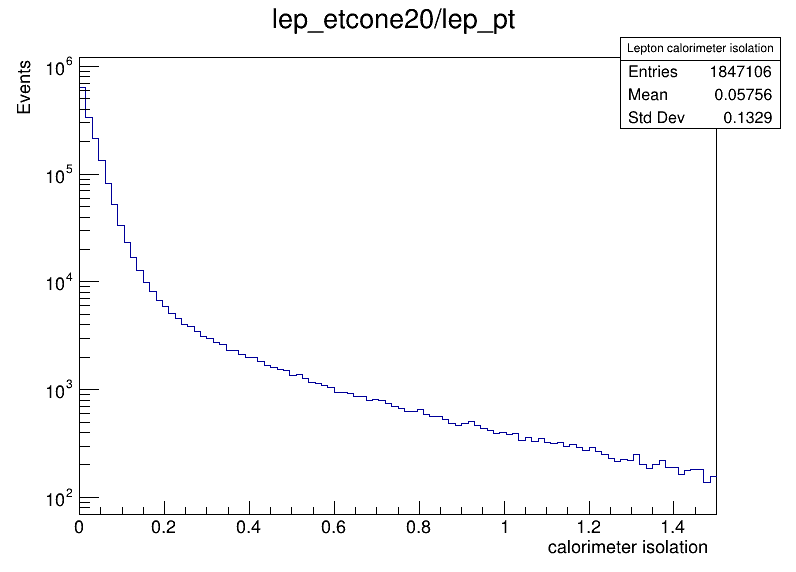

In [14]:
hist_lep_caloiso->Draw();
canvas->SetLogy();
canvas->Draw();

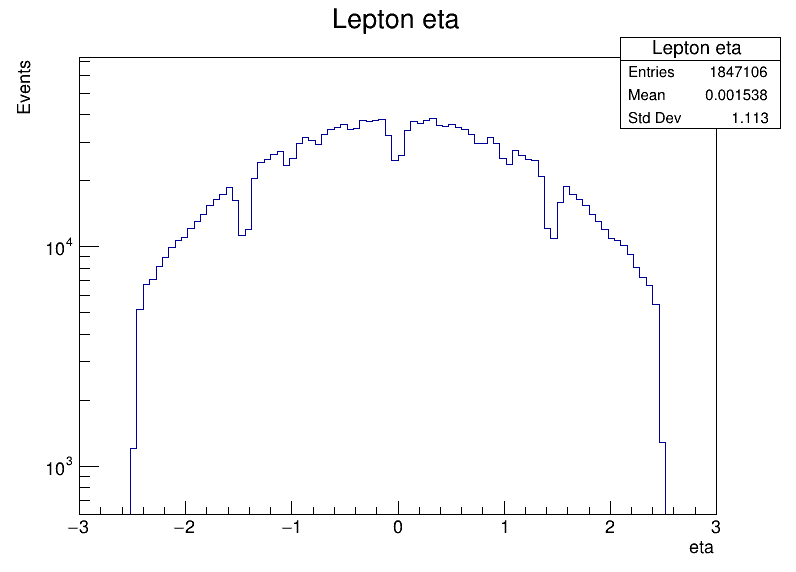

In [15]:
hist_lep_eta->Draw();
canvas->SetLogy();
canvas->Draw();

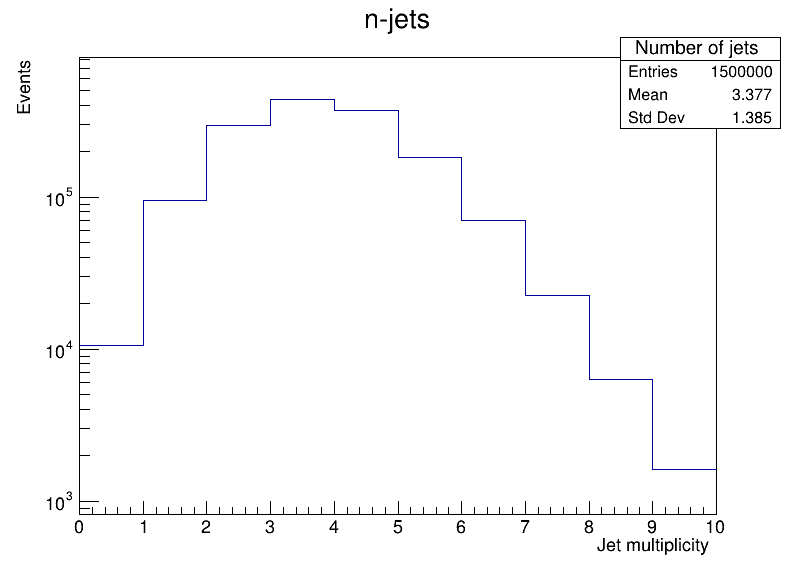

In [16]:
hist_njets->Draw();
canvas->SetLogy();
canvas->Draw();

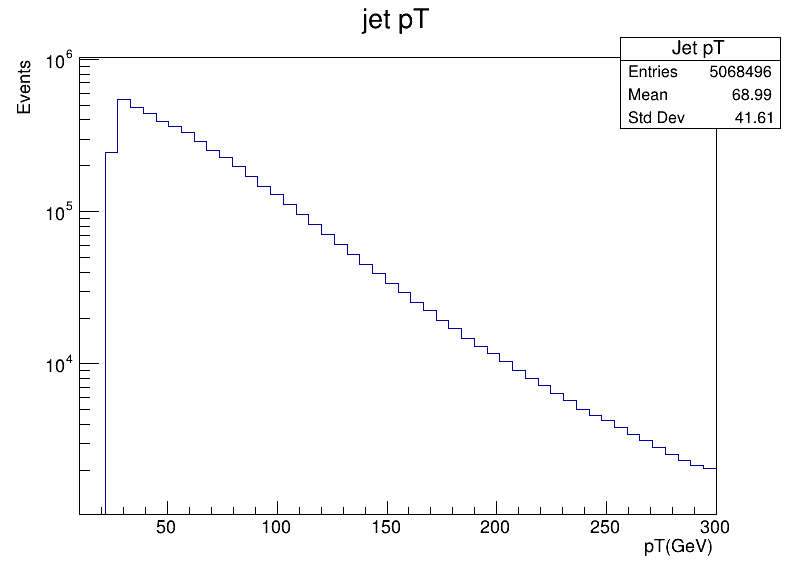

In [17]:
hist_jet_pt->Draw();
canvas->SetLogy();
canvas->Draw();

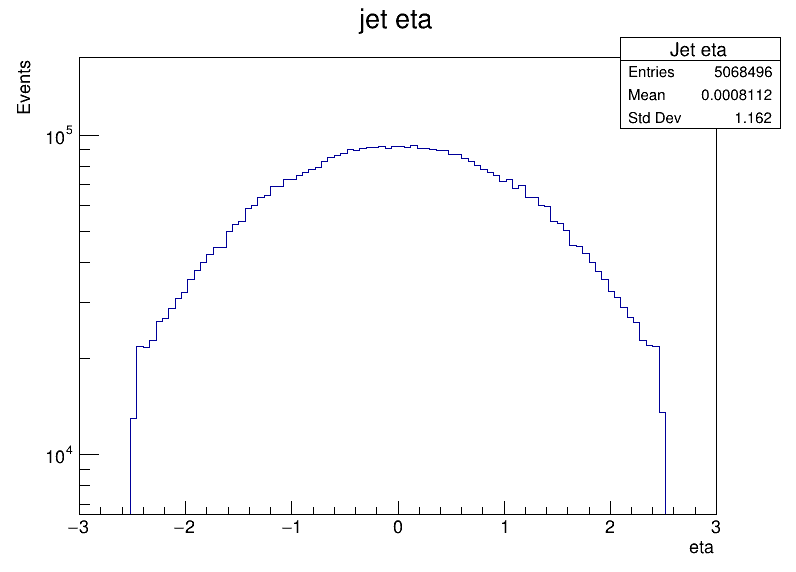

In [18]:
hist_jet_eta->Draw();
canvas->SetLogy();
canvas->Draw();

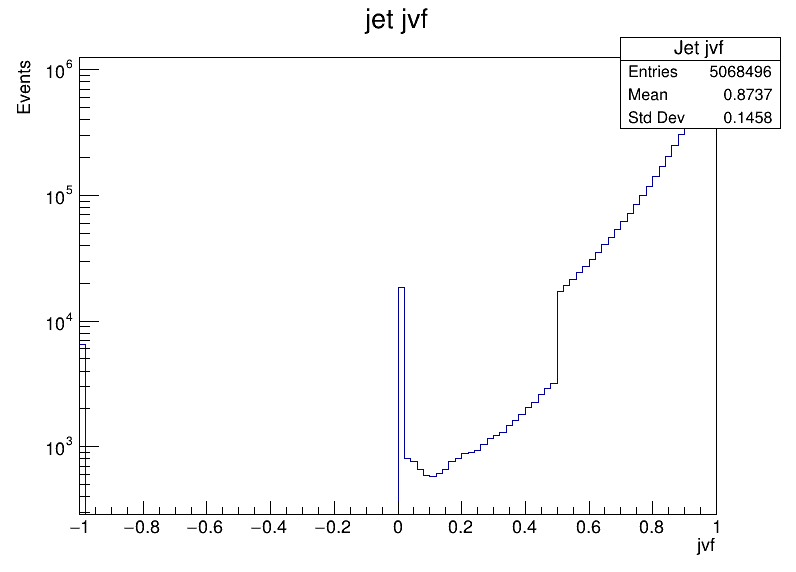

In [19]:
hist_jet_jvf->Draw();
canvas->SetLogy();
canvas->Draw();

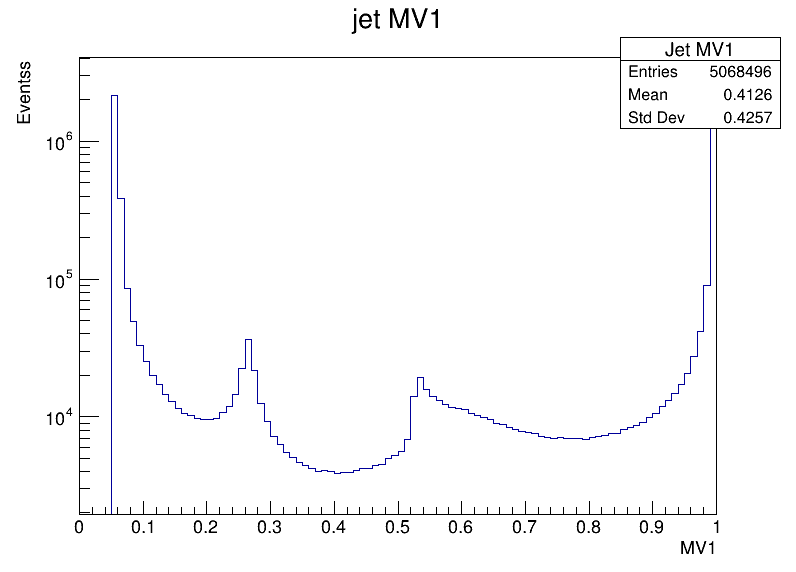

In [20]:
hist_jet_MV1->Draw();
canvas->SetLogy();
canvas->Draw();

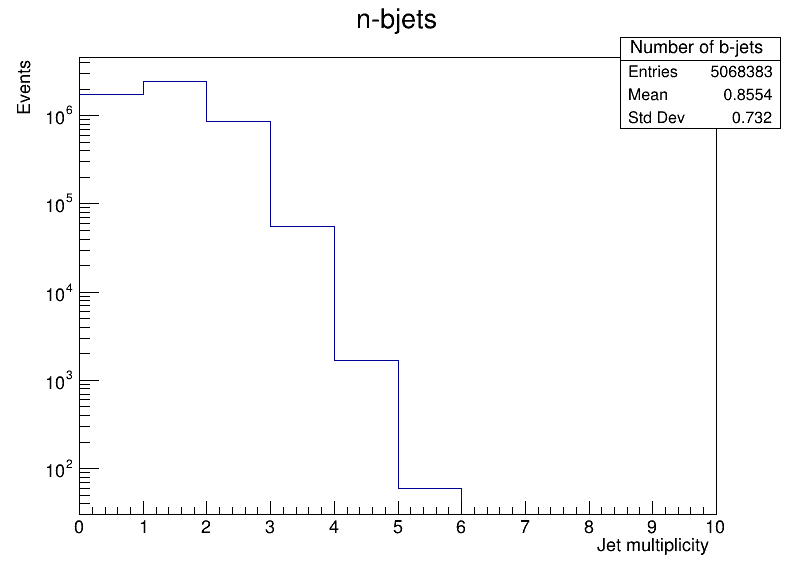

In [21]:
hist_nbjets->Draw();
canvas->SetLogy();
canvas->Draw();

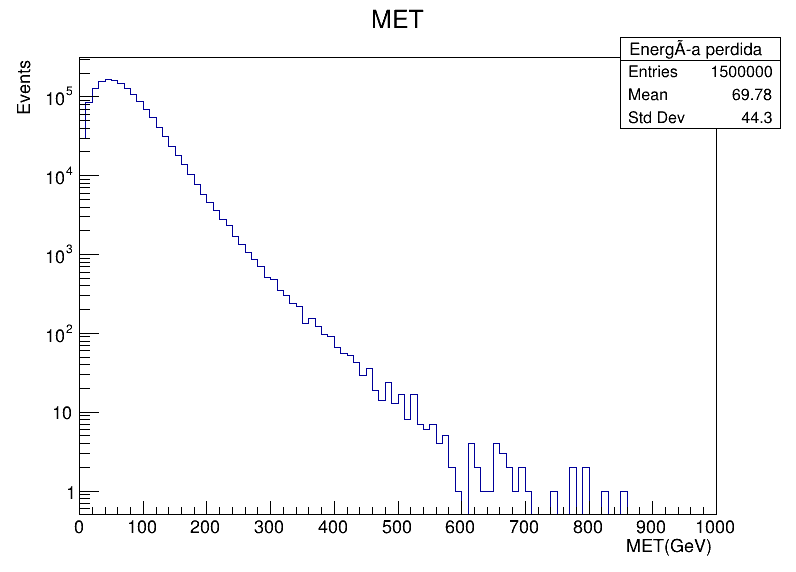

In [22]:
hist_MET->Draw();
canvas->SetLogy();
canvas->Draw();

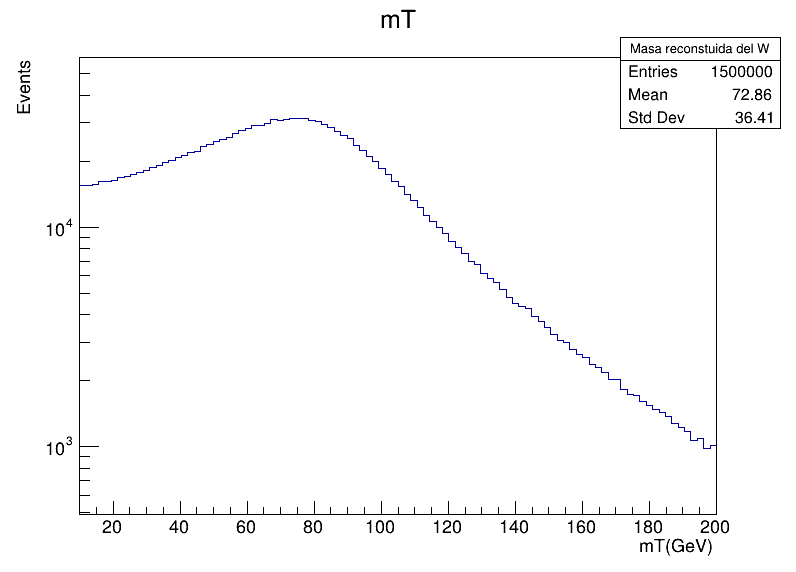

In [23]:
hist_mT->Draw();
canvas->Draw();

# Cuts for Monte-Carlo data with scaling:

In [7]:
Float_t eventWeight;
Float_t scaleFactor;
Float_t scaleFactor_PILEUP;
Float_t scaleFactor_ELE;
Float_t scaleFactor_MUON;
Float_t scaleFactor_BTAG;
Float_t scaleFactor_TRIGGER;
Float_t scaleFactor_JVFSF;
Float_t scaleFactor_ZVERTEX;
Float_t mcWeight;
Double_t evtw;

In [8]:
tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP);
tree->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE);
tree->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON);
tree->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG);
tree->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER);
tree->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF);
tree->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX);
tree->SetBranchAddress("mcWeight", &mcWeight);

In [9]:
TH1F *shist_lep_pt = new TH1F("Lepton pT","lepton pT; pT(GeV);Events",50,0,1000);
TH1F *shist_lep_trackiso = new TH1F("Lepton track isolation","lep_ptcone30/lep_pt; track isolation; Events",100,0,1.5);
TH1F *shist_lep_caloiso = new TH1F("Lepton calorimeter isolation","lep_etcone20/lep_pt; calorimeter isolation; Events",100,0,1.5);
TH1F *shist_lep_eta = new TH1F("Lepton eta","Lepton eta; eta; Events",100,-3,3);

TH1F *shist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);
TH1F *shist_jet_pt = new TH1F("Jet pT","jet pT; pT(GeV);Events",50,10,300);
TH1F *shist_jet_eta = new TH1F("Jet eta","jet eta; eta; Events",100,-3,3);
TH1F *shist_jet_jvf = new TH1F("Jet jvf","jet jvf; jvf; Events",100,-1,1);
TH1F *shist_jet_MV1 = new TH1F("Jet MV1","jet MV1; MV1; Eventss",100,0,1);

TH1F *shist_nbjets = new TH1F("Number of b-jets","n-bjets; Jet multiplicity; Events",10,0,10);

TH1F *shist_MET = new TH1F("Energía perdida","MET; MET(GeV); Events",100,0,1000);

TH1F *shist_mT = new TH1F("Masa reconstuida del W","mT; mT(GeV); Events",100,10,200);

In [10]:
Double_t L_MC=(0.072212854*49761200.21)/(137.29749*1000);
Double_t L_Data=1;
Double_t Weight = L_Data/L_MC;
std::cout << "Weight:" << Weight << std::endl;

Weight:0.0382083


In [11]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i); 
    //Event Weights
    evtw = scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_BTAG*scaleFactor_TRIGGER*scaleFactor_JVFSF*scaleFactor_ZVERTEX*mcWeight;
    
    //Zero cut
    cutflow->Fill(0.,evtw);
    // First cut: good vertex
    if(!good_vtx) continue;
        cutflow->Fill(1,evtw);
    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
        cutflow->Fill(2,evtw);
    //Loop over leptons
    int n_lep=0;
    for(unsigned int i=0; i<lep_n; i++){
        int n_mu=0;
        int n_el=0;
        if( lep_pt[i] <= 25000.) continue;
        if( lep_ptcone30[i]/lep_pt[i] >= 0.15 ) continue;
        if( lep_etcone20[i]/lep_pt[i] >= 0.15 ) continue;
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){n_mu++;}
        if( lep_type [i]==11 && (TMath::Abs(lep_eta[i])< 2.47 && TMath::Abs(lep_eta[i])>1.52 || TMath::Abs(lep_eta[i])<1.37 )){n_el++;}
        if(n_mu == 0 && n_el == 0) continue;
        n_lep++; 
    }
    //Third cut: one good lepton
    if(n_lep!=1) continue;
        cutflow->Fill(3,evtw);
    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
        cutflow->Fill(4,evtw);
    //Loop over jets
    int n_jets=0;
    int n_bjets=0;
    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j] <= 25000.) continue;
        if(TMath::Abs(jet_eta[j]) >= 2.5) continue;
        if(jet_pt[j] < 50000. && TMath::Abs(jet_eta[j])<2.4 && TMath::Abs(jet_jvf[j]>0.5)){n_jets++;}
        if(jet_pt[j] >= 50000. || TMath::Abs(jet_eta[j])>=2.4){n_jets++;}
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j]>=0.7892){n_bjets++;}
    }
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5,evtw);
    //Sixth cut: at least one b-jet
    if(n_bjets<2) continue;
    cutflow->Fill(6,evtw);
    //Seventh cut: MET > 30 GeV
    if(MET<=30000.) continue;
    cutflow->Fill(7,evtw);
    //Lorentz Vectors
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    float mTW; 
    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_E[0]);
    MeT.SetPtEtaPhiE(MET,0.,MET_phi,MET);
    //Calculation of the mTW using TLorentz vectors      
    mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    //Eight cut: mTW > 30 GeV*/
    if(mTW<=30000.) continue;
    cutflow->Fill(8,evtw);
    
    
    
    // Histograms
    for(unsigned int j=0; j<lep_n; j++){
        shist_lep_pt->Fill(lep_pt[j]/1000,evtw);
        shist_lep_trackiso->Fill(lep_ptcone30[j]/lep_pt[j],evtw);
        shist_lep_caloiso->Fill(lep_etcone20[j]/lep_pt[j],evtw);
        shist_lep_eta->Fill(lep_eta[j],evtw);
    }
    shist_njets->Fill(jet_n,evtw);
    for(unsigned int k=0; k<jet_n; k++){
       shist_jet_pt->Fill(jet_pt[k]/1000,evtw);
       shist_jet_jvf->Fill(jet_jvf[k],evtw);
       shist_jet_MV1->Fill(jet_MV1[k],evtw);
       shist_jet_eta->Fill(jet_eta[k],evtw);
       // b-jets 
       shist_nbjets->Fill(n_bjets,evtw);
    }
    shist_MET->Fill(MET/1000,evtw);
    shist_mT->Fill(mTW/1000,evtw);
}


In [12]:
int cut0 = cutflow->GetBinContent(1);
int cut1 = cutflow->GetBinContent(2);
int cut2 = cutflow->GetBinContent(3);
int cut3 = cutflow->GetBinContent(4);
int cut4 = cutflow->GetBinContent(5);
int cut5 = cutflow->GetBinContent(6);
int cut6 = cutflow->GetBinContent(7);
int cut7 = cutflow->GetBinContent(8);
int cut8 = cutflow->GetBinContent(9);

std::cout << "cut0:" << cut0 << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

cut0:1452182
Cut1:1451691
Cut2:1451691
Cut3:1295816
Cut4:610583
Cut5:609398
Cut6:229732
Cut7:188629
Cut8:159228


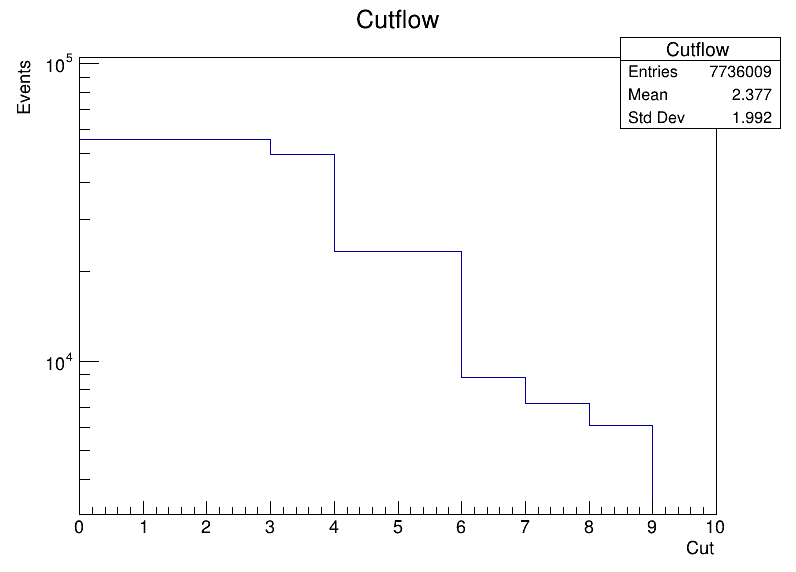

In [13]:
cutflow->Scale(Weight);
cutflow->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

# Histograms after all cuts for Monte Carlo data with scaling:

In other words, the data that we use to compare

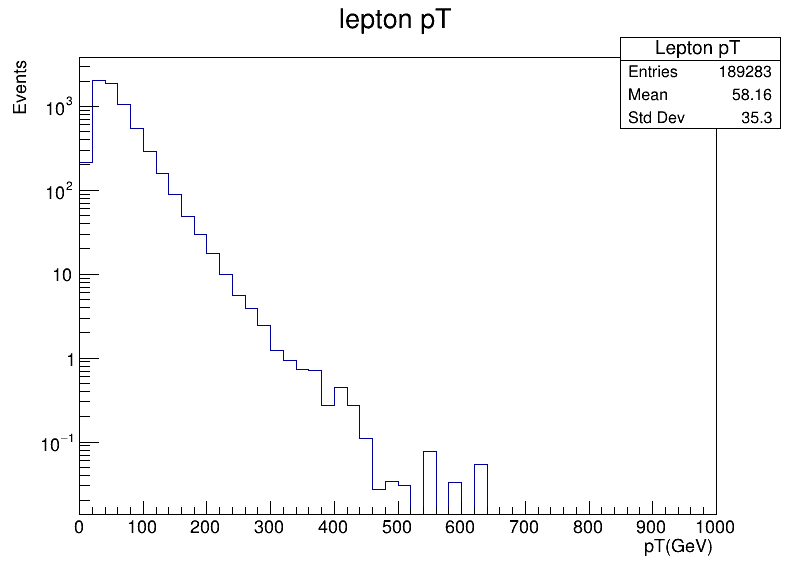

In [14]:
shist_lep_pt->Scale(Weight);
shist_lep_pt->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

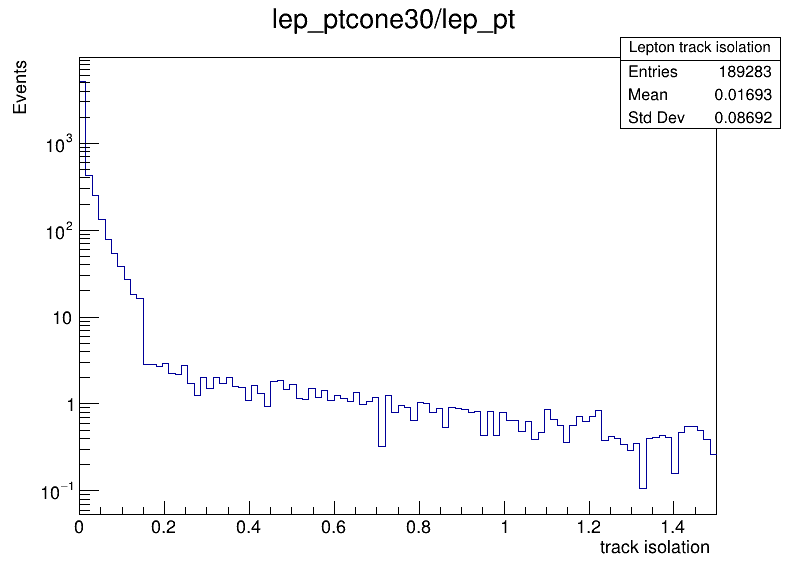

In [15]:
shist_lep_trackiso->Scale(Weight);
shist_lep_trackiso->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

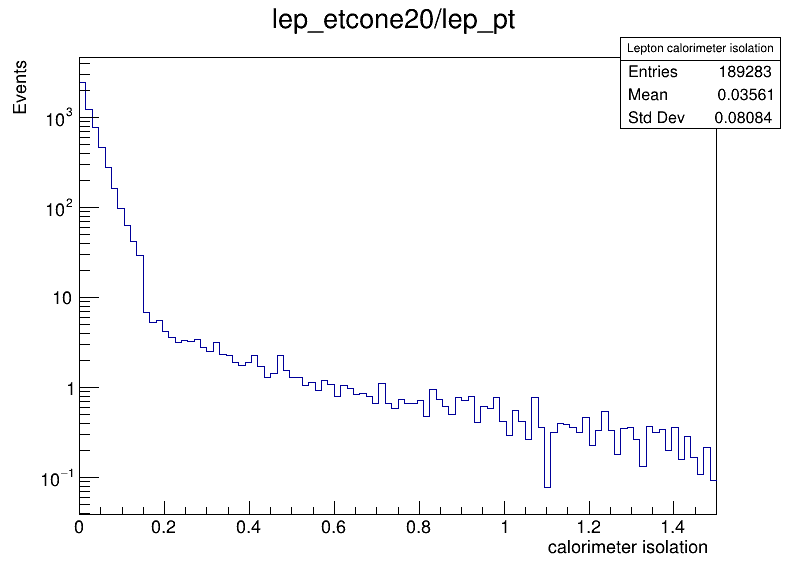

In [16]:
shist_lep_caloiso->Scale(Weight);
shist_lep_caloiso->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

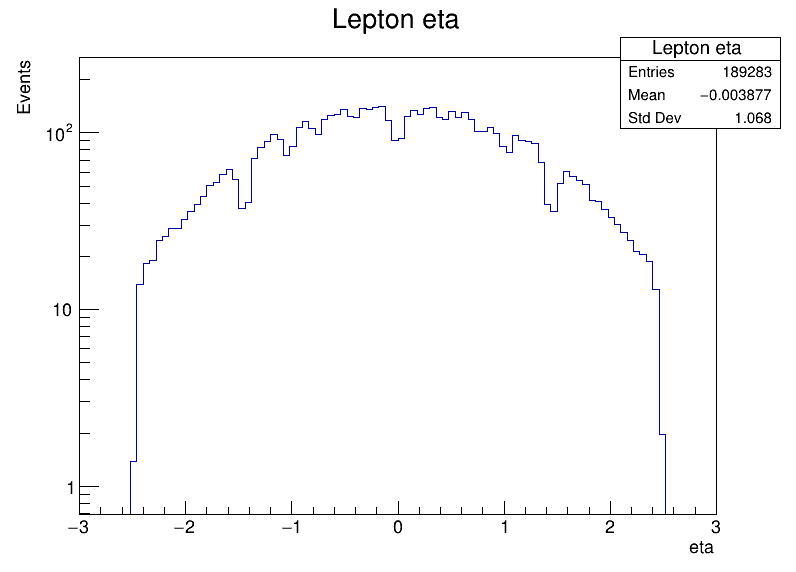

In [17]:
shist_lep_eta->Scale(Weight);
shist_lep_eta->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

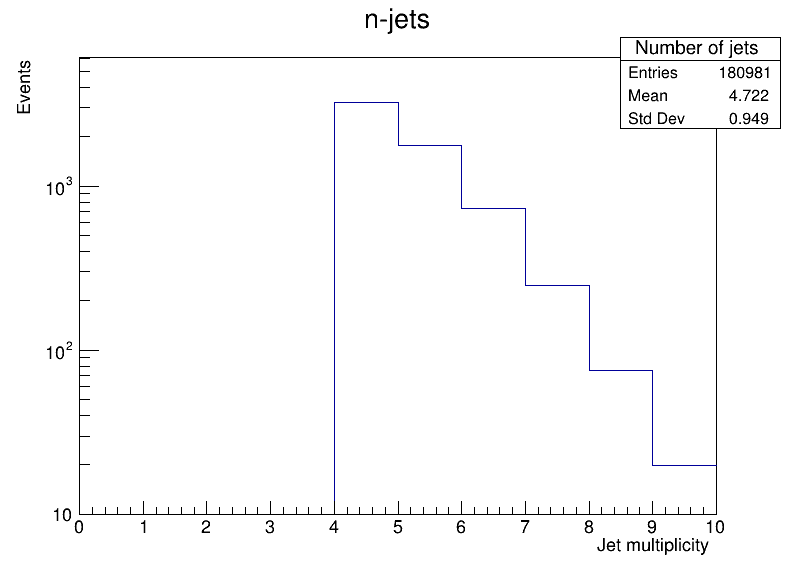

In [18]:
shist_njets->Scale(Weight);
shist_njets->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

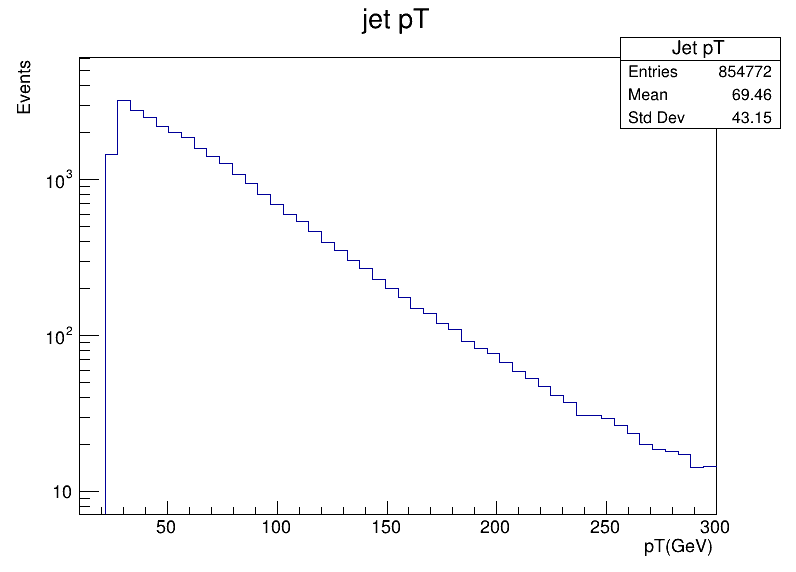

In [19]:
shist_jet_pt->Scale(Weight);
shist_jet_pt->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

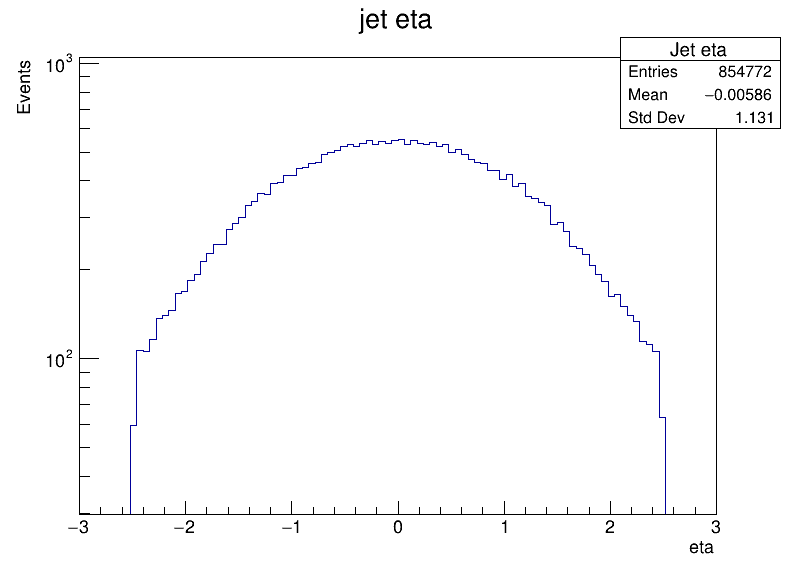

In [20]:
shist_jet_eta->Scale(Weight);
shist_jet_eta->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

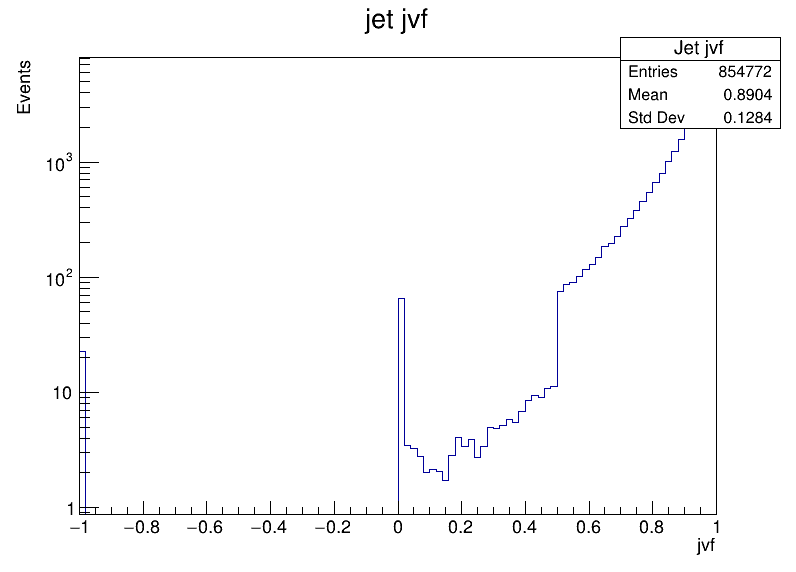

In [21]:
shist_jet_jvf->Scale(Weight);
shist_jet_jvf->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

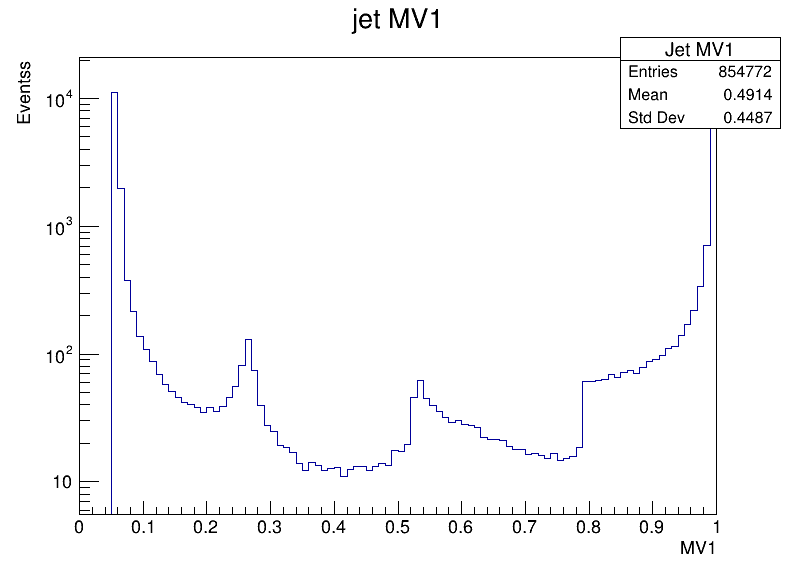

In [22]:
shist_jet_MV1->Scale(Weight);
shist_jet_MV1->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

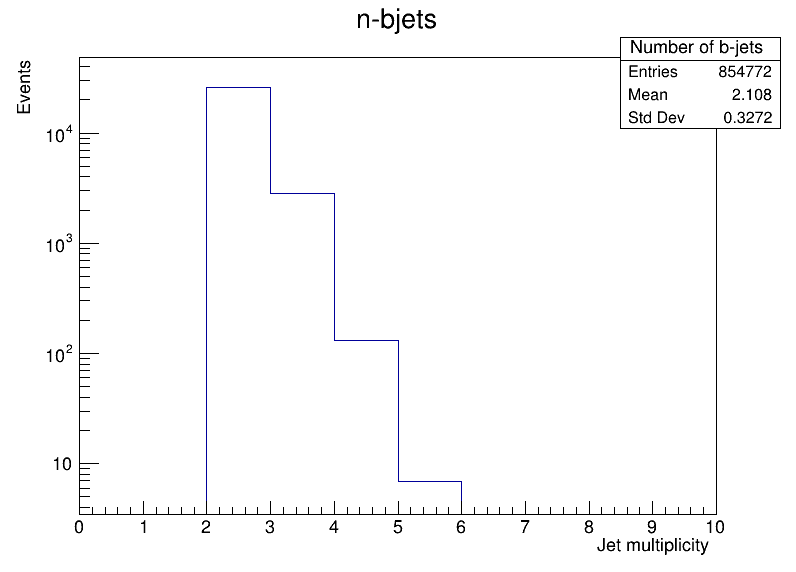

In [23]:
shist_nbjets->Scale(Weight);
shist_nbjets->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

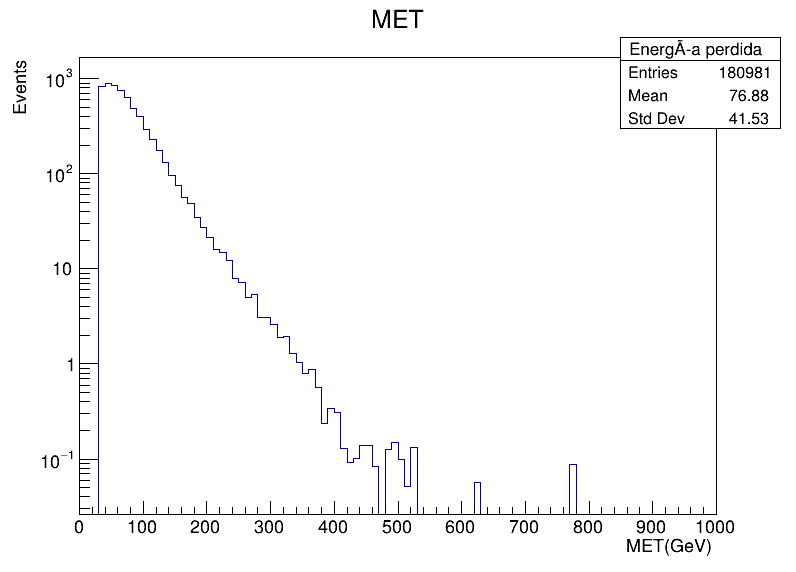

In [24]:
shist_MET->Scale(Weight);
shist_MET->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();

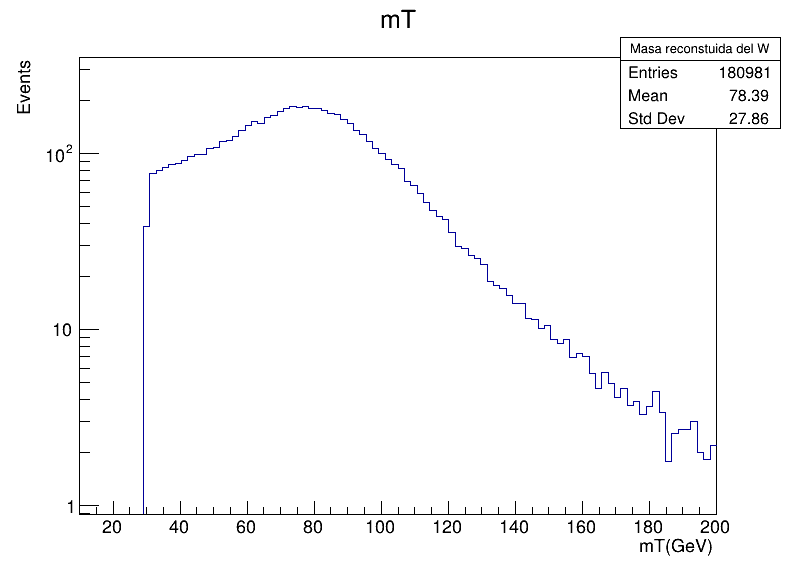

In [25]:
shist_mT->Scale(Weight);
shist_mT->Draw("HISTO");
canvas->SetLogy();
canvas->Draw();